In [ ]:
import torchvision.datasets

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
EMNIST_train = torchvision.datasets.EMNIST('EMNIST/processed/training.pt','byclass',train=True,download=True)
EMNIST_test = torchvision.datasets.EMNIST('EMNIST/processed/testing.pt','byclass',train=False,download=True)

Extracting EMNIST/processed/training.pt/EMNIST/raw/emnist.zip to EMNIST/processed/training.pt/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


Extracting EMNIST/processed/testing.pt/EMNIST/raw/emnist.zip to EMNIST/processed/testing.pt/EMNIST/raw
Processing byclass
Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:
X_train = EMNIST_train.train_data
y_train = EMNIST_train.train_labels
X_test = EMNIST_test.test_data
y_test = EMNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
len(y_train), len(y_test)


(697932, 116323)

In [ ]:
def preob(a):
    a = list(a)
    b= list(zip(*a[::-1]))
    for i in range(len(b)):
        b[i] = list(b[i])

    for i in range(28):
        for j in range(14):
            b[i][j],b[i][27-j] = b[i][27-j],b[i][j]
    return torch.tensor(b)





In [ ]:
X_test[101].shape

torch.Size([1, 28, 28])

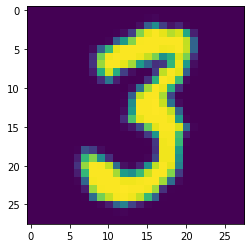

In [ ]:
#Измененый
import matplotlib.pyplot as plt
plt.imshow(X_test[101].reshape(28,28))
plt.show()

In [ ]:
for i in range(len(y_train)):
    X_train[i] = preob(X_train[i])
for j in range(len(y_test)):
    X_test[j] = preob(X_test[j])

In [ ]:
emn = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
archivator = dict({})
for i in range(62):
    archivator[i] = emn[i]


In [ ]:
X_train.shape

torch.Size([697932, 28, 28])

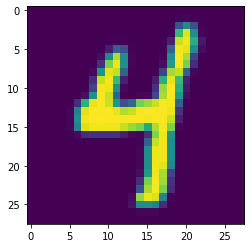

4


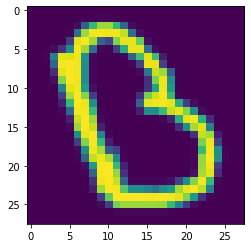

B


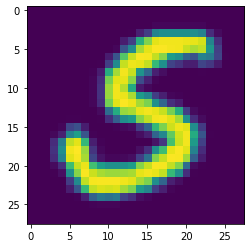

s


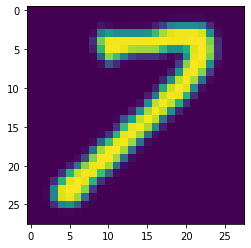

7


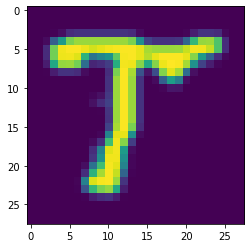

t


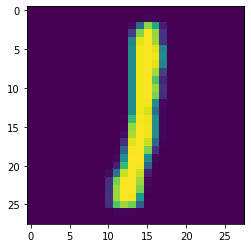

I


In [ ]:
import matplotlib.pyplot as plt

for i in range(100,106):
    plt.imshow(X_train[i].reshape(28,28))
    plt.show()
    print(archivator[int(y_train[i])])
#Сначало цифры(0-9),потом заглавные буквы(10-35),потом маленькие буквы(36-61)

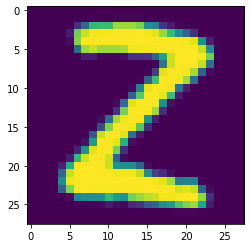

In [ ]:
plt.imshow(X_train[0].reshape(28,28))
plt.show()

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ELU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ELU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ELU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ELU()
        
        self.fc3   = torch.nn.Linear(84, 62)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)


In [ ]:
X_test.shape
X_test[0].shape

torch.Size([1, 28, 28])

In [ ]:
y_test[:5]

tensor([18, 36,  0,  3, 33])

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.8436)


In [ ]:
a = lenet5.forward(X_train[0:2])
archivator[int(a[0].argmax())]

'Y'

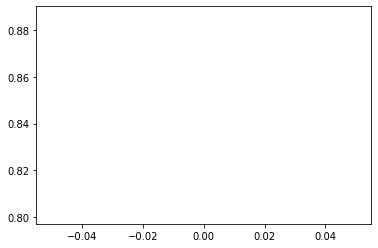

In [ ]:
plt.plot(test_accuracy_history);
#plt.plot(test_loss_history);

In [ ]:
import h5py
from keras.callbacks import ModelCheckpoint
weights_file = "weights.hdf5"
checkpoint = ModelCheckpoint(weights_file, monitor='acc', mode='max', save_best_only=True, verbose=1)

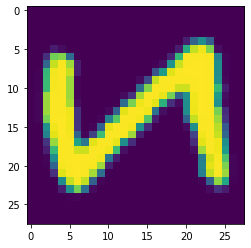

In [ ]:
plt.imshow(X_train[0].reshape(28,28))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
# random seed
seed = 101
np.random.seed(seed)
# load and split data
dataframe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
dataset = dataframe.values
X = dataset[:, 0:4].astype(float)
Y = dataset[:, 4]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# one-hot
dummy_y = np_utils.to_categorical(encoded_Y)
# split to test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=.25, random_state=seed)
# define model
def my_model():
    model = Sequential()
    model.add(Dense(4, input_dim=4, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, init='normal', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# save weights
weights_file = "weights.hdf5"
checkpoint = ModelCheckpoint(weights_file, monitor='acc', mode='max', save_best_only=True, verbose=1)
# fit
model = my_model()
model.fit(X_train, Y_train, batch_size=7, nb_epoch=200, verbose=1, callbacks=[checkpoint])
# save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#
#
#
# load model
jfile = open("model.json", "r")
loaded_json = jfile.read()
jfile.close()
loaded_model = model_from_json(loaded_json)
# weights
loaded_model.load_weights("weights.hdf5")
# compile model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# predict
predictions = loaded_model.predict_proba(X_test)
print('Accuracy: {}'.format(roc_auc_score(y_true=Y_test, y_score=predictions)))

In [ ]:

from keras.callbacks import ModelCheckpoint

# save weights
weights_file = "wom.h5"
checkpoint = ModelCheckpoint(weights_file, monitor='acc', mode='max', save_best_only=True, verbose=1)





## weights
#lenet5.load_weights("wom.hdf5")


ModuleAttributeError: ignored

In [ ]:
##torch.save(lenet5)

#torch.load()
#
#torch.nn.Module().load_state_dict()

In [ ]:
torch.save(lenet5, 'ModelEm(1).json')

In [ ]:

# Загрузка необходимых библиотек и модулей

import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой 
import time    # Библиотека для работы со временем

from google.colab import drive # Модуль для работы с Google Disk

In [ ]:
# Подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
the_model = torch.load('/content/drive/My Drive/Detection/ModelEm.json')

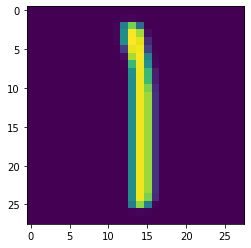

1


In [ ]:
plt.imshow(X_test[701].reshape(28,28))
plt.show()
print(archivator[int(y_test[701])])

In [ ]:
b = the_model.forward(X_test[701:702])
archivator[int(b[0].argmax())]

'1'